## Target Web Scraping
### Olivia Petronio, Nishtha Sharma, and Ellison Holloway 

We wanted to compare grocery store prices, but we found that the government's data was lacking. So, we opted to obtain our own data by scraping data from Target, obtaining prices for various goods across all 50 states.

Starting with our imports, of course.

In [2]:
# --- Scraper + Analysis Script ---
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler



### Scraping
After the imports, comes the scraping. This was quite the lengthy process, as the scraper needed to work through each region, and each state in said region, and the chosen zip codes in each state, for each of the items that are in our basket.

Below is an example of the scraping code for one region, in this case West North Central.

In [ ]:
# --- Product Data ---
products = [
    ("Bananas", "https://www.target.com/p/organic-bananas-2lb-good-38-gather-8482/-/A-85759852#lnk=sametab"),
    ("Vegetable Oil", "https://www.target.com/p/vegetable-oil-good-gather/-/A-89467834?preselect=78376315#lnk=sametab"),
    ("Gum", "https://www.target.com/p/extra-spearmint-sugarfree-gum-15ct/-/A-13307857#lnk=sametab"),
    ("Toilet Paper", "https://www.target.com/p/cottonelle-ultra-comfort-toilet-paper/-/A-54605704?preselect=75665830#lnk=sametab"),
    ("AirPods", "https://www.target.com/p/apple-airpods-4/-/A-93606140?preselect=85978618#lnk=sametab"),
    ("Cotton Swabs", "https://www.target.com/p/q-tips-cotton-swabs-375ct/-/A-11223546#lnk=sametab"),
    ("Diapers", "https://www.target.com/p/pampers-swaddlers-active-baby-diapers-select-size-and-count/-/A-14783999?preselect=53461432#lnk=sametab"),
    ("T-Shirt", "https://www.target.com/p/women-s-linen-short-sleeve-t-shirt-universal-thread/-/A-93711326?preselect=92878440#lnk=sametab"),
    ("Eggs", "https://www.target.com/p/grade-a-large-eggs-12ct-good-38-gather-8482-packaging-may-vary/-/A-14713534#lnk=sametab"),
    ("Shampoo", "https://www.target.com/p/native-coconut-vanilla-moisturizing-shampoo/-/A-94666723?preselect=80120273#lnk=sametab"),
    ("Milk", "https://www.target.com/p/milk-good-gather/-/A-94602358?preselect=13276134#lnk=sametab")
]

#       rural, suburban, urban
zips = ['50702', '50009', '52404',
        '67401', '66062', '66111',
        '56601', '55066', '55403',
        '63010', '63033', '64114',
        '68073', '68123', '68116',
        '58563', '58701', '58103',
        '57701', '57401', '57110']

location = ['Waterloo, IA', 'Altoona, IA', 'Cedar Rapids, IA',
            'Salina, KS', 'Olathe, KS', 'Kansas City, KS',
            'Bemidji, MN', 'Red Wing, MN', 'Minneapolis, MN',
            'Arnold, MO', 'Florissant, MO', 'Kansas City, MO',
            'Yutan, NE', 'Bellevue, NE', 'Omaha, NE',
            'New Salem, ND', 'Minot, ND', 'Fargo, ND',
            'Rapid City, SD', 'Aberdeen, SD', 'Sioux Falls, SD']

city_town = ['Rural', 'Suburban', 'Urban',
             'Rural', 'Suburban', 'Urban',
             'Rural', 'Suburban', 'Urban',
             'Rural', 'Suburban', 'Urban',
             'Rural', 'Suburban', 'Urban',
             'Rural', 'Suburban', 'Urban',
             'Rural', 'Suburban', 'Urban'] 


combined_data = []

# --- Setup Driver ---
def setup_driver():
    options = Options()
    options.add_argument("--disable-blink-features=AutomationControlled")
    options.add_argument("--window-size=1920x1080")
    driver = webdriver.Firefox(options=options)
    driver.set_page_load_timeout(30)
    return driver

def close_modal(driver):
    try:
        WebDriverWait(driver, 5).until(
            EC.element_to_be_clickable((By.CLASS_NAME, "styles_overlay__3ZDC1"))
        )
        close_btn = driver.find_element(By.CLASS_NAME, "styles_overlay__3ZDC1")
        driver.execute_script("arguments[0].click();", close_btn)
        time.sleep(2)
    except:
        pass

# --- Scraping Loop ---
for product_name, url in products:
    print(f"📦 Scraping {product_name}...")
    driver = setup_driver()
    try:
        driver.get(url)
        time.sleep(5)
        close_modal(driver)

        price_element = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.XPATH, "//span[contains(@data-test, 'product-price')]"))
        )
        price = price_element.text
        #combined_data.append({"Product": product_name, "Zip Code": zips[0], "Price": price})
        print(f"✅ Zip Code: {zips} , Price: {price}")
        time.sleep(2)

        for zip_code in zips:
            try:
                time.sleep(2)
                
                edit_buttons = driver.find_elements(By.XPATH, '//*[@id="web-store-id-msg-btn"]/div/div[2]/span')
                time.sleep(3)
                if not edit_buttons:
                    print(f"❌ Could not find 'Edit your location' for zip {zip_code}")
                    continue
                edit_buttons[0].click()
                time.sleep(1)
                zip_input = driver.find_element(By.XPATH, '//*[@id="zip-or-city-state"]')
                zip_input.send_keys(Keys.COMMAND + "a")
                zip_input.send_keys(Keys.BACKSPACE)
                zip_input.send_keys(zip_code)
                time.sleep(1)
                
                print("Clicking the button to update zip")
                
                lookup = driver.find_element(By.XPATH, "/html/body/div[5]/div/div/div[2]/div[1]/div/div[1]/div[2]/button")
                lookup.click()
                time.sleep(3)
                
                first_available_store = driver.find_element(By.XPATH, "/html/body/div[5]/div/div/div[2]/div[2]/fieldset/div[1]/div/div[1]/label")
                first_available_store.click()
                time.sleep(1)
                
                shop_this_store = driver.find_element(By.XPATH, "/html/body/div[5]/div/div/div[3]/button")
                shop_this_store.click()
                time.sleep(3)
                
                price_element = WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.XPATH, "//span[contains(@data-test, 'product-price')]"))
                )
                price = price_element.text
                combined_data.append({"Product": product_name, "Zip Code": zip_code, "Price": price})
                print(f"✅ Zip Code: {zip_code} , Price: {price}")

            except Exception as e:
                print(f"❌ Error processing zip {zip_code}: {e}")
    except Exception as e:
        print(f"❌ Error on main product for {product_name}: {e}")
    finally:
        driver.quit()

### Cleanup and Exploratory Analysis
With our data scraped, it can immediately be processed through the cleanup code, analyzed, and saved as a .csv file for future use.

There is also a version below this cell that instead works with uploaded .csv files instead of the dataframe outputted from the scraping program, just in case we need to do analysis on data that has already been saved.

In [ ]:
# Updated! This cleans up the data and saves to to a csv, alongside printing the statistics.
# --- Data Cleanup ---
df = pd.DataFrame(combined_data)
display(df)
zip_map = dict(zip(zips, zip(location, city_town)))
df['Location'] = df['Zip Code'].map(lambda z: zip_map.get(z, ["", ""])[0])
df['Area Type'] = df['Zip Code'].map(lambda z: zip_map.get(z, ["", ""])[1])
df['Price'] = df['Price'].replace('[\$,]', '', regex=True).astype(float)

# --- Category Mapping ---
category_map = {
    "Bananas": "Food", "Vegetable Oil": "Food", "Gum": "Snack", "Toilet Paper": "Toiletries",
    "AirPods": "Electronics", "Cotton Swabs": "Toiletries", "Diapers": "Baby Care",
    "T-Shirt": "Clothing", "Eggs": "Food", "Shampoo": "Toiletries", "Milk": "Food"
}
df["Category"] = df["Product"].map(category_map)

df.to_csv("target_prices_combined.csv", index=False)
print("✅ All product data saved to target_prices_combined.csv")

# --- EDA + Visualization ---
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x="Category", y="Price")
plt.title("Price Distribution by Product Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

pivot = df.pivot_table(index="Product", columns="Zip Code", values="Price", aggfunc='mean')
print("\n📊 Average Price by Product and ZIP Code:\n")
print(pivot)

print("\n📉 Product Price Variability (Standard Deviation):\n")
print(df.groupby("Product")["Price"].std())

# Linear Regression: Area Type → Price
df_reg = df.copy()
df_reg['Area Code'] = df_reg['Area Type'].map({'Suburban': 0, 'City': 1, 'Urban': 2})
df_reg = df_reg.dropna(subset=['Area Code'])

X = sm.add_constant(df_reg['Area Code'])
y = df_reg['Price']
model = sm.OLS(y, X).fit()
print("\n📈 Linear Regression Summary (Area Code → Price):\n")
print(model.summary())

# K-Means Clustering
pivot_df = df.pivot_table(index="Zip Code", columns="Product", values="Price")
pivot_df = pivot_df.dropna()
if pivot_df.shape[0] >= 2:
    scaler = StandardScaler()
    scaled = scaler.fit_transform(pivot_df)
    kmeans = KMeans(n_clusters=2, random_state=42)
    pivot_df['Cluster'] = kmeans.fit_predict(scaled)
    print("\n ZIP Code Clusters:\n")
    print(pivot_df['Cluster'])
else:
    print("\n Not enough ZIP Codes with full product prices to perform clustering.")

# Group Means
print("\n🏙️ Average Price by Area Type:\n")
print(df.groupby(['Area Type'])['Price'].mean())

print("\n📊 Average Price by Category and Area Type:\n")
print(df.groupby(['Category', 'Area Type'])['Price'].mean().unstack())

# Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Price Variation of Products by ZIP Code")
plt.tight_layout()
plt.show()


# In[ ]:

In [ ]:
# This version of the code just displays the statistics, importing from a csv so we don't have to re-run the scrapes.
# --- Data Cleanup ---
df = pd.read_csv("target_prices_combined_mountain.csv")
display(df)

# --- Category Mapping ---
category_map = {
    "Bananas": "Food", "Vegetable Oil": "Food", "Gum": "Snack", "Toilet Paper": "Toiletries",
    "AirPods": "Electronics", "Cotton Swabs": "Toiletries", "Diapers": "Baby Care",
    "T-Shirt": "Clothing", "Eggs": "Food", "Shampoo": "Toiletries", "Milk": "Food"
}
df["Category"] = df["Product"].map(category_map)


# --- EDA + Visualization ---
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x="Category", y="Price")
plt.title("Price Distribution by Product Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

pivot = df.pivot_table(index="Product", columns="Zip Code", values="Price", aggfunc='mean')
print("\n📊 Average Price by Product and ZIP Code:\n")
print(pivot)

print("\n📉 Product Price Variability (Standard Deviation):\n")
print(df.groupby("Product")["Price"].std())

# Linear Regression: Area Type → Price
df_reg = df.copy()
df_reg['Area Code'] = df_reg['Area Type'].map({'Suburban': 0, 'City': 1, 'Urban': 2})
df_reg = df_reg.dropna(subset=['Area Code'])

X = sm.add_constant(df_reg['Area Code'])
y = df_reg['Price']
model = sm.OLS(y, X).fit()
print("\n📈 Linear Regression Summary (Area Code → Price):\n")
print(model.summary())

# K-Means Clustering
pivot_df = df.pivot_table(index="Zip Code", columns="Product", values="Price")
pivot_df = pivot_df.dropna()
if pivot_df.shape[0] >= 2:
    scaler = StandardScaler()
    scaled = scaler.fit_transform(pivot_df)
    kmeans = KMeans(n_clusters=2, random_state=42)
    pivot_df['Cluster'] = kmeans.fit_predict(scaled)
    print("\n ZIP Code Clusters:\n")
    print(pivot_df['Cluster'])
else:
    print("\n Not enough ZIP Codes with full product prices to perform clustering.")

# Group Means
print("\n🏙️ Average Price by Area Type:\n")
print(df.groupby(['Area Type'])['Price'].mean())

print("\n📊 Average Price by Category and Area Type:\n")
print(df.groupby(['Category', 'Area Type'])['Price'].mean().unstack())

# Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Price Variation of Products by ZIP Code")
plt.tight_layout()
plt.show()

### Cleaning the Data
Now that the data is saved, it is further cleaned, so that it can be concatenated into one large file, various variables can be added, and exported as one combined .csv file.

In [ ]:
# Getting and cleaning the data.

file_names = ["target_prices_combined_east_south_central",
              "target_prices_combined_mountain",
              "target_prices_combined_pacific",
              "target_prices_combined_south_atlantic",
              "target_prices_combined_west_north_central",
              "target_prices_combined_west_south_central",
              "target_prices_NE",
              "target_prices_NEC_full",
              "target_pricing_MA"]

for file in file_names:
    globals()[file] = pd.read_csv("scraped data to combine into full dataframe/" + file + ".csv")

    
# This is the section where I clean up some of the data so I can mash it all together in a sec.

# Starting with defining some functions that I'll use to clean the data, of course.

# Some zips aren't 5 numbers long.
def zip_extender_and_stringifier(code):
    if len(str(int(code))) != 5:
        return "0" + str(int(code))
    return str(int(code))

def price_floater(price):
    # I did not need to make this one line. I probably should not have made this one line. But I did anyways, because it made me feel awesome.
    return float(price.split('$')[-1].split('.')[0]) + float(price.split('$')[-1].split('.')[1])/100

def rent_floater(price):
    # This is just price floater, but for thousands instead of tens with decimals.
    if "," in price:
        return float(price.split('$')[-1].split(',')[0])*1000 + float(price.split('$')[-1].split(',')[1])
    else:
        return float(price.split('$')[-1])

def airpod_capitalizer(product):
    if product == 'Airpods':
        return 'AirPods'
    return product

def classification_fixer(classification):
    return classification.title().split(' ')[0]


target_prices_NE = target_prices_NE.drop("Unnamed: 5", axis=1)  # Drops mysterious sixth column.
target_prices_NE = target_prices_NE.dropna()  # Removes null values from data.
target_prices_NE["Zip Code"] = target_prices_NE["Zip Code"].apply(zip_extender_and_stringifier)  # Fixes zips being registered as floats
target_prices_NE["Price"] = target_prices_NE["Price"].apply(price_floater)  # Turns prices into floats
target_prices_NE["Classification"] = target_prices_NE["Classification"].apply(classification_fixer)  # Fixes capitalization on classifications
target_prices_NE = target_prices_NE.rename(columns={'Classification': 'Area Type'})  # ...only to immediately rename the column.

# Doing the same with the other two. I tried to do this as a loop, but pandas didn't like that very much.
target_prices_NEC_full = target_prices_NEC_full.dropna()
target_prices_NEC_full["Zip Code"] = target_prices_NEC_full["Zip Code"].apply(zip_extender_and_stringifier)
target_prices_NEC_full["Price"] = target_prices_NEC_full["Price"].apply(price_floater)
target_prices_NEC_full["Classification"] = target_prices_NEC_full["Classification"].apply(classification_fixer)
target_prices_NEC_full["Product"] = target_prices_NEC_full["Product"].apply(airpod_capitalizer) # This one changes Airpods to AirPods, to match the others' capitalization of the word. 
target_prices_NEC_full = target_prices_NEC_full.rename(columns={'Classification': 'Area Type'})

target_pricing_MA = target_pricing_MA.dropna()
target_pricing_MA["Zip Code"] = target_pricing_MA["Zip Code"].apply(zip_extender_and_stringifier)
target_pricing_MA["Price"] = target_pricing_MA["Price"].apply(price_floater)
target_pricing_MA["Classification"] = target_pricing_MA["Classification"].apply(classification_fixer)
target_pricing_MA = target_pricing_MA.rename(columns={'Classification': 'Area Type'})


# I messed up some of my data collection, so I'm fixing that manually(ish) for the files I know are affected.

target_prices_combined_mountain = target_prices_combined_mountain.drop(range(0,275,25))
target_prices_combined_mountain = target_prices_combined_mountain.drop(range(10,275,25))  # I accidentally duplicated 59718. I'm gonna have to re-scrape mountain later. fml.

target_prices_combined_pacific = target_prices_combined_pacific.drop(range(0,165,15))

target_prices_combined_west_south_central = target_prices_combined_west_south_central.drop(range(0,143,13))


# I have no idea why my code is breaking. i'm just gonna try this out of desperation.
target_prices_combined_east_south_central["Zip Code"] = target_prices_combined_east_south_central["Zip Code"].apply(zip_extender_and_stringifier)
target_prices_combined_mountain["Zip Code"] = target_prices_combined_mountain["Zip Code"].apply(zip_extender_and_stringifier)
target_prices_combined_pacific["Zip Code"] = target_prices_combined_pacific["Zip Code"].apply(zip_extender_and_stringifier)
target_prices_combined_south_atlantic["Zip Code"] = target_prices_combined_south_atlantic["Zip Code"].apply(zip_extender_and_stringifier)
target_prices_combined_west_north_central["Zip Code"] = target_prices_combined_west_north_central["Zip Code"].apply(zip_extender_and_stringifier)
target_prices_combined_west_south_central["Zip Code"] = target_prices_combined_west_south_central["Zip Code"].apply(zip_extender_and_stringifier)
# Oh hey, this actually fixed it! Well I'm keeping these here because they make all the column additions good.



# And now I get to pivot and combine them. This part's really satisfying.

files_to_concat = []

for file in file_names:
    df = globals()[file]
    
    print("pivoting", file)
    product_prices = df.pivot(index='Zip Code', columns='Product', values='Price')
    
    print("location+class for", file)
    location_and_class = df.drop_duplicates("Zip Code")
    location_and_class = location_and_class.drop(['Product', 'Price'], axis=1)
    try:
        location_and_class = location_and_class.drop('Category', axis=1)
    except:
        pass
    location_and_class = location_and_class.set_index('Zip Code')

    print("combining", file)
    out4 = pd.concat([product_prices, location_and_class], axis=1)
    #display(out4)
    print("done!")
    
    globals()["pivot_" + file] = out4  # I don't know if I'll need this? but I'll keep it in, just in case people want individual files.
    files_to_concat.append(globals()["pivot_" + file])  # This adds it to the list of frames to concat together.

full_data = pd.concat(files_to_concat)
display(full_data)



# This data is found from this website: https://warehouse.ninja/target-distribution-center-locations/
# I inputted it manually, unfortunately.

warehouse_data = [[34.6449932755897,-86.8473292167007],
                  [33.44847758394,-112.216516477379],
                  [35.4443517679111,-119.184883986437],
                  [34.1129032695058,-117.481059984653],
                  [34.1556649469121,-117.430952966951],
                  [33.8829312577458,-117.266820757673],
                  [38.6830449523077,-121.721678642205],
                  [34.1342886776624,-117.416355370662],
                  [38.2782732480079,-104.467643668806],
                  [39.8102931481305,-104.986460657673],
                  [30.2323049532679,-82.6359163730191],
                  [31.7765737205048,-81.3526562288365],
                  [31.7776443503854,-81.3539269910744],
                  [31.4215451402305,-83.5182432359064],
                  [32.1739955290448,-81.1755252030619],
                  [21.4792398115305,-158.016842329534],
                  [41.9176226241567,-88.7369320728707],
                  [41.8303900458523,-87.7238539644176],
                  [41.8002418685309,-87.7811810344034],
                  [41.4744170168815,-88.1627609565227],
                  [41.9218023710286,-87.9598046121732],
                  [39.7475498809776,-86.2948367214139],
                  [42.4760732243742,-92.468984016849],
                  [38.9662278505392,-95.6943807344034],
                  [38.8653486027871,-76.7299089768994],
                  [44.9647972364202,-85.2029499259567],
                  [45.0979857630195,-93.2491908864199],
                  [44.9933873277923,-93.2149055171079],
                  [44.9452591409893,-92.9121249623863],
                  [40.5251569148739,-74.2592140725181],
                  [40.089765436428,-74.8200981032102],
                  [39.7817015818632,-75.3450861543144],
                  [43.178721716844,-73.7161892865095],
                  [42.9386799514717,-74.2384685711634],
                  [35.6225966445846,-81.3098264595263],
                  [39.9520393926857,-83.3482983306921],
                  [39.9471432044632,-83.3518352558173],
                  [44.5794790802794,-123.115068328716],
                  [40.1989563009857,-76.8052668801052],
                  [39.8890231958012,-77.6729397],
                  [34.1794119094042,-80.6818378840045],
                  [32.4347483116907,-97.0555079725181],
                  [34.5570298314302,-97.1446958584889],
                  [32.8696311238109,-95.6389149051154],
                  [32.8807284643133,-96.901032357673],
                  [29.9461573473188,-95.5288642134904],
                  [38.0306730381623,-78.998851715346],
                  [36.7076274133422,-76.6651214220913],
                  [47.0821524927726,-122.771626284653],
                  [43.080037381646,-88.4760084558174],
                  [42.4825228934735,-92.4709803136662]]
# This data is from this website: https://gist.github.com/pramodpendyala/e5688b6a63d2983eac804bbaa1fd7cc0

address_data = pd.read_csv('2023_Gaz_zcta_national.txt', sep="\t", header=None)
address_data.columns = address_data.iloc[0]
address_data = address_data.drop(0)
# Why is the column name like this. Who is responsible. I just want to talk.
address_data.rename(columns={'INTPTLONG                                                                                                                                  ':'INTPTLONG'}, inplace=True)

address_data['INTPTLAT'] = address_data['INTPTLAT'].apply(lambda x: float(x))
address_data['INTPTLONG'] = address_data['INTPTLONG'].apply(lambda x: float(x))

address_data = address_data.drop(["ALAND", "AWATER", "ALAND_SQMI", "AWATER_SQMI"], axis=1)

address_data = address_data.rename(columns={'GEOID': 'Zip Code'})
address_data = address_data.set_index('Zip Code')



full_data = full_data.join(address_data, how='left')

def closest_to_distro_center(row):
    distances = []
    
    
    for coordinate in warehouse_data:
        # I'll be honest, I have no idea how this works. I don't know most of my trig knowledge anymore, and I am trusting this stackoverflow person with my life.
        # https://stackoverflow.com/questions/365826/calculate-distance-between-2-gps-coordinates
        earth_radius = 3959  # This is earth's radius in miles. I can switch this to fm by changing the number to 6371
        
        distance_lat = math.radians(row["INTPTLAT"] - coordinate[0])
        distance_lon = math.radians(row["INTPTLONG"] - coordinate[1])
        
        lat1 = math.radians(row["INTPTLAT"])
        lat2 = math.radians(coordinate[0])
        
        a = pow(math.sin(distance_lat / 2), 2) + (pow(math.sin(distance_lon / 2), 2) * math.cos(lat1) * math.cos(lat2))
        
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        distances.append(earth_radius * c)
        
    
    return min(distances)


full_data["Closest Distro Center"] = full_data.apply(closest_to_distro_center, axis=1)

full_data = full_data.drop(["INTPTLAT", "INTPTLONG"], axis=1)
display(full_data)


# Ok now to add the rent data to the columns.

rent = pd.read_csv("scraped data to combine into full dataframe/df_rent.csv")
#display(rent)
rent = rent.drop(["Unnamed: 9", "Unnamed: 10", "Unnamed: 11", "Unnamed: 12", "Unnamed: 13", "Unnamed: 14", "Unnamed: 15", "Unnamed: 16", "Unnamed: 17", "Unnamed: 18", "Unnamed: 19"], axis=1)
#display(rent)
rent = rent.dropna()
rent = rent.rename(columns={'ZIP': 'Zip Code'})
rent["Zip Code"] = rent["Zip Code"].apply(zip_extender_and_stringifier)  # Fixes zips being registered as floats
rent = rent.set_index('Zip Code')
#display(rent)
rent["Studio"] = rent["Studio"].apply(rent_floater)
rent["1BR"] = rent["1BR"].apply(rent_floater)
rent["2BR"] = rent["2BR"].apply(rent_floater)
rent["3BR"] = rent["3BR"].apply(rent_floater)
rent["4BR"] = rent["4BR"].apply(rent_floater)

full_data = full_data.join(rent, how='left')



# And I'll also make sure to add income.

income = pd.read_excel("scraped data to combine into full dataframe/Med_income.xlsx")
income = income.drop("Unnamed: 3", axis=1)
income = income.rename(columns={'ZIP': 'Zip Code'})
income["Zip Code"] = income["Zip Code"].apply(zip_extender_and_stringifier)  # Fixes zips being registered as floats
income = income.set_index('Zip Code')


full_data = full_data.join(income, how='left')

full_data = full_data.drop_duplicates()

display(full_data)

# When importing the data as a CSV, make sure to turn the zip code back into an index so it doesn't get in the way.
# I have an example of doing this in the data modeling file, right at the top in the clustering section.
full_data.to_csv("full_data.csv")

### Data Modeling
Now that the data is sufficiently clean, we can model the data in various ways. Starting by once again importing the data from csv.

In [3]:

# Bringing in the data.
# I do this for both linear regression and clustering, so I feel like I should have it happen out here.

data = pd.read_csv("full_data.csv")

# Sure is annoying having to redefine this. Oh, well!
def zip_extender_and_stringifier(code):
    if len(str(int(code))) != 5:
        return "0" + str(int(code))
    return str(int(code))
data["Zip Code"] = data["Zip Code"].apply(zip_extender_and_stringifier)

data = data.set_index('Zip Code')




### Clustering!
First, we ran clustering models on the data, to see if there were any obvious groups that the Targets seemed to fall under.

In [6]:

#display(data)
# I can't have any categorical variables for clustering, unfortunately.
data_clustering_version = data.copy()
data_clustering_version = data_clustering_version.drop(["Location", "Area Type", "Division", "Region"], axis=1)
data_clustering_version = data_clustering_version.fillna(method='ffill')

# Averaging the rent to try and get more conclusive results.
data_averaging_for_rent = data_clustering_version.drop(["AirPods", "Bananas", "Cotton Swabs", "Diapers", "Eggs", "Gum", "Milk", "Shampoo", "T-Shirt", "Toilet Paper", "Vegetable Oil", "Closest Distro Center", "Unemployment Rate", "Median Income", "Population"], axis=1)
data_averaging_for_rent = data_averaging_for_rent.mean(axis=1)

data_clustering_version["Rent"] = data_averaging_for_rent
data_clustering_version = data_clustering_version.drop(["Studio", "1BR", "2BR", "3BR", "4BR"], axis=1)

#display(data_clustering_version)



# Specify the number of clusters
k = 4

# Create k-means object and fit the data
kmeans = KMeans(n_clusters=k)
kmeans.fit(data_clustering_version)

# Get cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Print results
#print("Cluster labels:", labels)
#print("Centroids:", centroids)

data_clustering_results = data.copy()

data_clustering_results["Cluster"] = labels

data_clustering_results = data_clustering_results.sort_values(["Cluster", "Zip Code"])


# When importing the data as a CSV, make sure to turn the zip code back into an index so it doesn't get in the way.
# Uncomment the line below if you'd prefer to export to a csv instead of working in this file.
# data_clustering_results.to_csv("clustered_data.csv")

display(data_clustering_results)



,AirPods,Bananas,Cotton Swabs,Diapers,Eggs,Gum,Milk,Shampoo,T-Shirt,Toilet Paper,...,Studio,1BR,2BR,3BR,4BR,Division,Region,Median Income,Population,Cluster
Zip Code,,,,,,,,,,,,,,,,,,,,,
02865,179.99,1.99,3.39,44.99,4.99,1.69,3.89,9.99,9.6,12.99,...,1233.0,1319.0,1614.0,1945.0,2359.0,New England,Northeast,117042.0,17902.0,0
02886,NaN,1.99,NaN,44.99,4.99,1.79,NaN,NaN,9.6,NaN,...,1233.0,1319.0,1614.0,1945.0,2359.0,New England,Northeast,91037.0,29373.0,0
02917,179.99,1.99,3.39,44.99,5.99,1.69,3.89,9.99,9.6,12.99,...,1233.0,1319.0,1614.0,1945.0,2359.0,New England,Northeast,106924.0,16036.0,0
03063,179.99,1.99,3.39,44.99,4.99,1.69,3.49,9.99,9.6,12.99,...,1184.0,1192.0,1564.0,1917.0,2405.0,New England,Northeast,106924.0,16036.0,0
05403,179.99,1.99,3.39,44.99,4.99,1.69,3.49,9.99,NaN,12.99,...,1380.0,1476.0,1936.0,2491.0,2567.0,New England,Northeast,97041.0,20166.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87402,179.99,1.99,3.39,44.99,4.99,1.79,3.39,9.99,9.6,12.99,...,841.0,855.0,1034.0,1449.0,1571.0,Mountain,West,76992.0,11646.0,3
89705,179.99,1.99,3.39,44.99,1.49,1.79,4.69,9.99,9.6,12.99,...,1004.0,1199.0,1464.0,2051.0,2458.0,Mountain,West,78269.0,5266.0,3
98233,179.99,1.99,3.39,44.99,1.99,1.79,3.49,9.99,9.6,12.99,...,1166.0,1300.0,1701.0,2384.0,2592.0,Pacific,West,83560.0,16034.0,3


### Linear Regression!
After clustering was shown to be inconclusive, it was time to look at linear regression, to see if increases/decreases in product pricing correlate with other factors.

---Model for AirPods---
Mean Squared Error: 3.2311742677852644e-27
Coefficients for AirPods:
	Bananas: 5.606752724327861e-25
	Cotton Swabs: 1.689324508519133e-24
	Diapers: -1.1231242407832314e-34
	Eggs: 1.3009420687833573e-26
	Gum: 1.3474331506376855e-25
	Milk: 2.631296795156804e-27
	Shampoo: -2.5046664529486486e-24
	T-Shirt: -4.040761830951668e-39
	Toilet Paper: -1.9869172727670675e-24
	Vegetable Oil: 2.4106291286997103e-24
	Closest Distro Center: 2.2075903188610686e-29
	Unemployment Rate: -8.901410916187791e-28
	Median Income: 1.1314053345920259e-31
	Population: -2.360988776986313e-31
	Rent: -7.329706357753063e-30

Leading coeff for AirPods is Shampoo


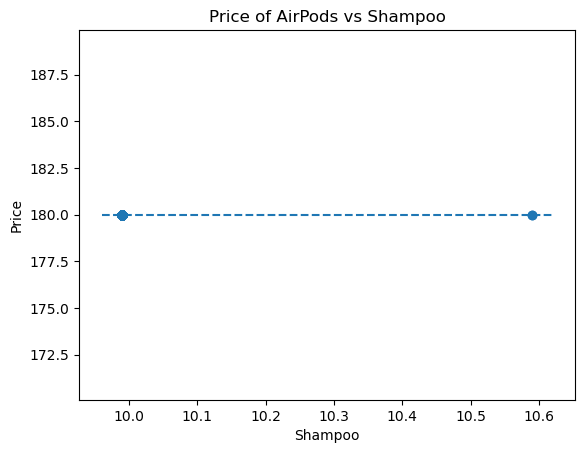

---Model for Bananas---
Mean Squared Error: 0.005470462719585023
Coefficients for Bananas:
	AirPods: 1.1631252261329559e-16
	Cotton Swabs: -1.8945573821983706
	Diapers: -3.334067263840837e-11
	Eggs: -0.01024717891774895
	Gum: -0.5764513405559278
	Milk: 0.009887195234284236
	Shampoo: 1.7167722144303583
	T-Shirt: -2.3240552116796252e-12
	Toilet Paper: 2.873707164114434
	Vegetable Oil: -2.76928082106676
	Closest Distro Center: -0.00013646955405904356
	Unemployment Rate: -0.006629788781902837
	Median Income: -5.521830222196958e-07
	Population: 5.050973033790745e-07
	Rent: 2.3591080042040036e-07

Leading coeff for Bananas is Toilet Paper


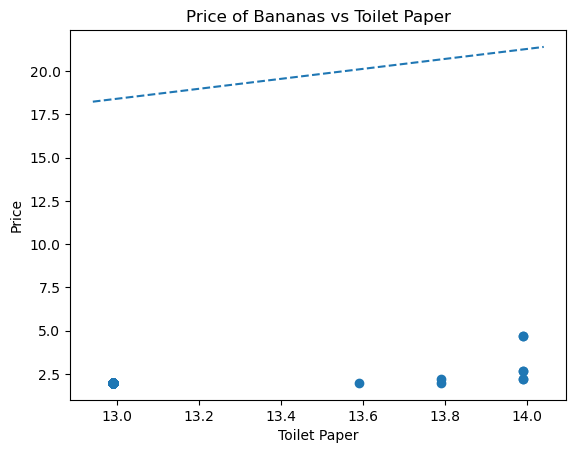

---Model for Cotton Swabs---
Mean Squared Error: 0.189542250757936
Coefficients for Cotton Swabs:
	AirPods: 1.7282178633145075e-17
	Bananas: 0.520344351509131
	Diapers: -1.3280759228234205e-13
	Eggs: -0.008724594832066765
	Gum: -0.11631754395210227
	Milk: -0.004624769080119367
	Shampoo: 0.49384585771152895
	T-Shirt: 2.4524879038453528e-14
	Toilet Paper: 0.5683598986264097
	Vegetable Oil: -0.5796502754405534
	Closest Distro Center: 1.5487849090482938e-05
	Unemployment Rate: -0.00027847600579560016
	Median Income: -3.4871106996569916e-07
	Population: 4.447087467729368e-08
	Rent: 1.2492097112189675e-05

Leading coeff for Cotton Swabs is Vegetable Oil


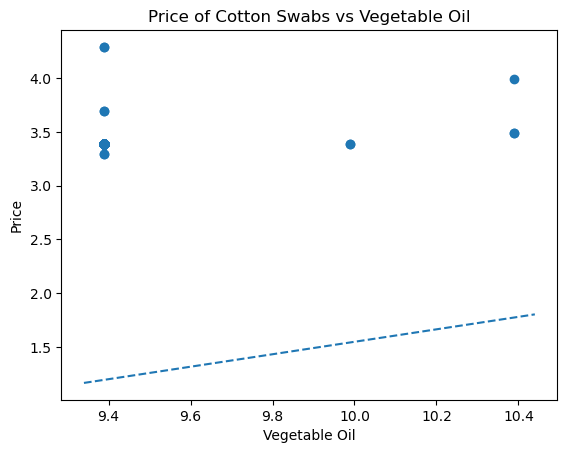

---Model for Diapers---
Mean Squared Error: 2.0194839173657902e-28
Coefficients for Diapers:
	AirPods: -6.47858161257954e-42
	Bananas: -3.8333535895154835e-26
	Cotton Swabs: -9.410737741206009e-26
	Eggs: 2.3251989349660052e-28
	Gum: -1.8965282081344377e-26
	Milk: -8.479986430412589e-30
	Shampoo: 9.687179025799205e-26
	T-Shirt: -2.2312129785995125e-38
	Toilet Paper: 1.3267450780167987e-25
	Vegetable Oil: -1.3686971315105143e-25
	Closest Distro Center: -3.988485933432236e-30
	Unemployment Rate: -1.8842319779811007e-28
	Median Income: -2.703308041022905e-32
	Population: 4.4696741341852625e-33
	Rent: 2.0854400161998737e-31

Leading coeff for Diapers is Vegetable Oil


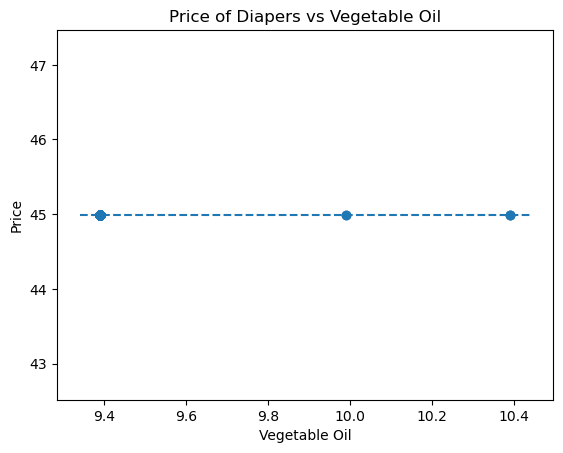

---Model for Eggs---
Mean Squared Error: 5.092642568763891
Coefficients for Eggs:
	AirPods: 5.703055430525916e-16
	Bananas: -5.864010637078262
	Cotton Swabs: -13.357688574283461
	Diapers: 8.120770156893429e-11
	Gum: -2.581942822820719
	Milk: -0.08586622906145798
	Shampoo: 19.020287953040132
	T-Shirt: 4.415539872909179e-11
	Toilet Paper: 17.331462279497355
	Vegetable Oil: -22.38830498129517
	Closest Distro Center: -0.00033888336778595344
	Unemployment Rate: 0.010490223842693856
	Median Income: -2.1667614619882194e-06
	Population: 5.911780863276559e-06
	Rent: 6.257122536865311e-05

Leading coeff for Eggs is Vegetable Oil


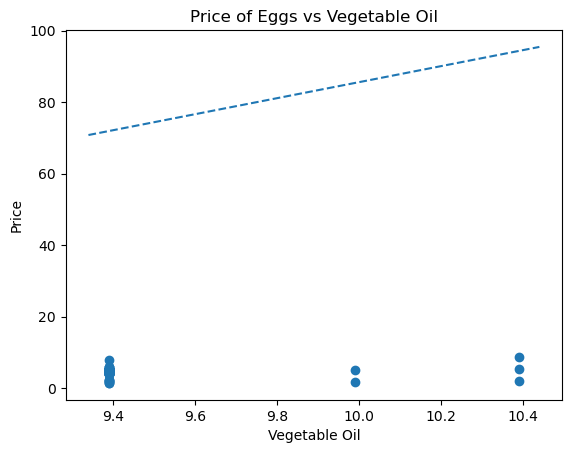

---Model for Gum---
Mean Squared Error: 0.0018355793720662985
Coefficients for Gum:
	AirPods: -1.3139717731768293e-17
	Bananas: -0.10557787490314756
	Cotton Swabs: -0.2957821340847607
	Diapers: -5.969985047815354e-13
	Eggs: -0.007817759272714225
	Milk: -0.0040527621970241935
	Shampoo: 0.11637495565480926
	T-Shirt: 1.3995188932193576e-13
	Toilet Paper: 0.39496561518376555
	Vegetable Oil: -0.27071119283090767
	Closest Distro Center: 0.00014129521969891547
	Unemployment Rate: -0.0010591431470447035
	Median Income: -2.7602289547336407e-07
	Population: 2.6826235452559e-07
	Rent: 8.72870144759839e-06

Leading coeff for Gum is Toilet Paper


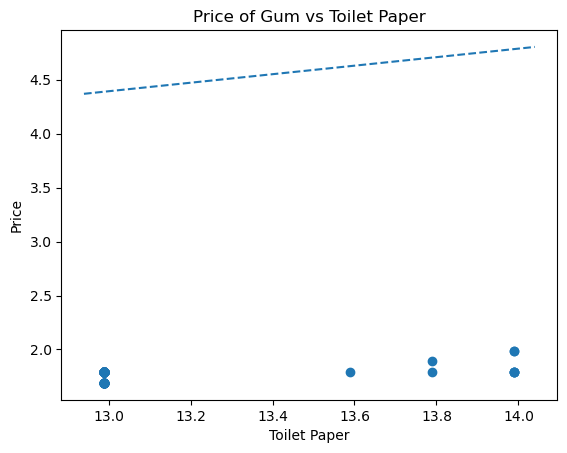

---Model for Milk---
Mean Squared Error: 0.7342061036621796
Coefficients for Milk:
	AirPods: -1.0174560540408247e-16
	Bananas: 0.09510815194439773
	Cotton Swabs: -4.262374187120044
	Diapers: 1.0370054905410558e-11
	Eggs: -0.03768915565209479
	Gum: -0.5076044549837763
	Shampoo: 3.03422979299249
	T-Shirt: 2.174177957468629e-13
	Toilet Paper: 3.527955589691742
	Vegetable Oil: -3.49310942963843
	Closest Distro Center: 0.0006669238537228695
	Unemployment Rate: -0.010049190746591994
	Median Income: -6.9125221559346715e-06
	Population: -6.280646301132397e-06
	Rent: 0.00016653553289744505

Leading coeff for Milk is Cotton Swabs


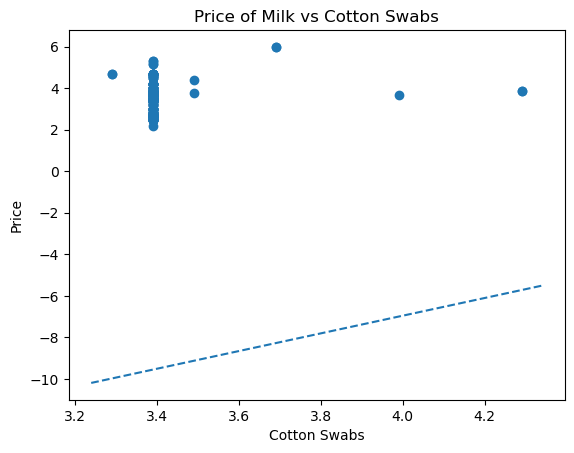

---Model for Shampoo---
Mean Squared Error: 0.00026820623989124624
Coefficients for Shampoo:
	AirPods: 6.573509733464267e-17
	Bananas: 0.21883757622485198
	Cotton Swabs: 0.801738994975003
	Diapers: -5.293953108234389e-13
	Eggs: -0.003928941531465775
	Gum: 0.1214467521160713
	Milk: 0.0014690296568958473
	T-Shirt: -2.865759878907389e-13
	Toilet Paper: -0.8524982128937946
	Vegetable Oil: 0.936549138621834
	Closest Distro Center: -5.057455309175704e-05
	Unemployment Rate: -0.0009452226157258482
	Median Income: 5.584089906562153e-08
	Population: 1.2355001987480346e-08
	Rent: 1.7889506132978355e-06

Leading coeff for Shampoo is Vegetable Oil


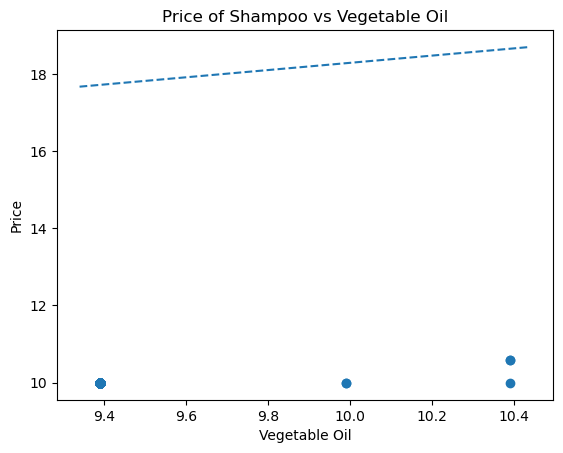

---Model for T-Shirt---
Mean Squared Error: 5.048709793414476e-29
Coefficients for T-Shirt:
	AirPods: -3.870595509398698e-49
	Bananas: -3.8220238414755625e-26
	Cotton Swabs: -9.906344041366111e-26
	Diapers: 2.5105117270858594e-38
	Eggs: 4.772733150991867e-29
	Gum: -2.201478784180086e-27
	Milk: -4.646896532384373e-29
	Shampoo: 7.360775047315155e-26
	Toilet Paper: 1.3068249018496359e-25
	Vegetable Oil: -1.2098688659460473e-25
	Closest Distro Center: -7.427357956925395e-30
	Unemployment Rate: -2.8553195284969616e-28
	Median Income: -1.5365430103106906e-32
	Population: 3.179621208236549e-33
	Rent: 4.582686520966782e-31

Leading coeff for T-Shirt is Toilet Paper


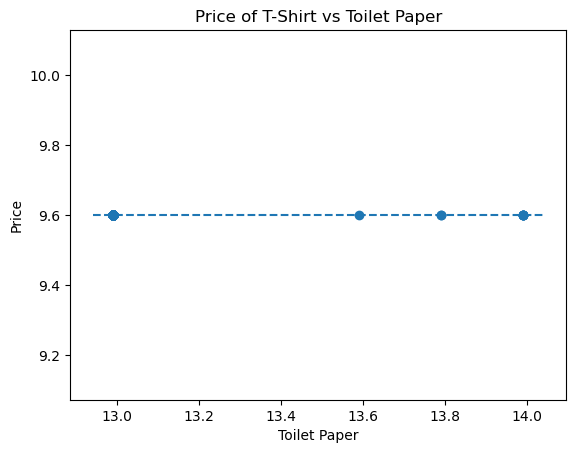

---Model for Toilet Paper---
Mean Squared Error: 0.00018080912163194444
Coefficients for Toilet Paper:
	AirPods: 1.2050712830834902e-17
	Bananas: 0.28449860286078676
	Cotton Swabs: 0.7487366177604744
	Diapers: 1.3376706264761224e-12
	Eggs: 0.0011219996648307313
	Gum: 0.22732827760602053
	Milk: 0.0019368092367992784
	Shampoo: -0.6426441459006654
	T-Shirt: 6.069542574030166e-13
	Vegetable Oil: 0.9634668899975904
	Closest Distro Center: 2.413540727005454e-05
	Unemployment Rate: 0.0015820887198929596
	Median Income: 2.218282461307792e-07
	Population: -1.6614880814211744e-07
	Rent: 7.948461071795266e-07

Leading coeff for Toilet Paper is Vegetable Oil


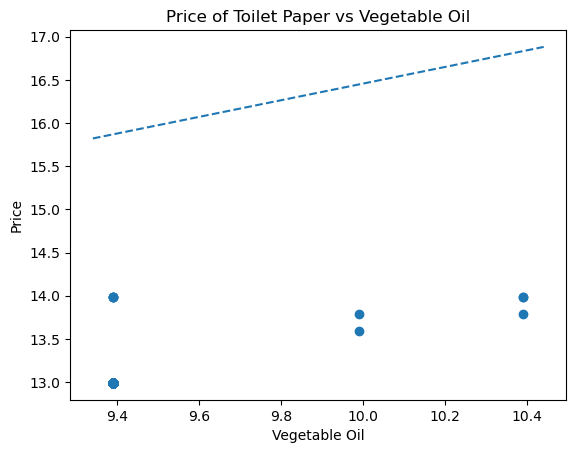

---Model for Vegetable Oil---
Mean Squared Error: 8.336344302728673e-05
Coefficients for Vegetable Oil:
	AirPods: 7.593300138417652e-18
	Bananas: -0.2758892349957403
	Cotton Swabs: -0.7247960370527907
	Diapers: 1.4553739332594285e-13
	Eggs: 0.001966151853114304
	Gum: -0.14450934072158061
	Milk: -0.0014240256190771123
	Shampoo: 0.7232484731079305
	T-Shirt: 6.059905394283303e-15
	Toilet Paper: 0.9724236355848346
	Closest Distro Center: -3.6793751725454554e-05
	Unemployment Rate: -0.001447903433621095
	Median Income: -1.7539302479775683e-07
	Population: 6.297875680750768e-08
	Rent: 2.332085265567922e-06

Leading coeff for Vegetable Oil is Toilet Paper


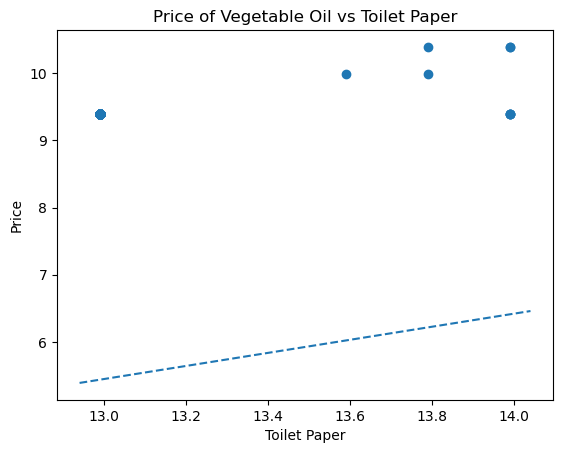

done!


In [7]:

# Linear Regression! I think I got everything I need for this? I kinda wish it had more visualization to it, but I couldn't really do that.

data_modeling_version = data.drop(["Location", "Area Type", "Division", "Region"], axis=1)
data_modeling_version = data_modeling_version.fillna(method='ffill')

# Averaging the rent to try and get more conclusive results.
data_averaging_for_rent = data_modeling_version.drop(["AirPods", "Bananas", "Cotton Swabs", "Diapers", "Eggs", "Gum", "Milk", "Shampoo", "T-Shirt", "Toilet Paper", "Vegetable Oil", "Closest Distro Center", "Unemployment Rate", "Median Income", "Population"], axis=1)
data_averaging_for_rent = data_averaging_for_rent.mean(axis=1)

data_modeling_version["Rent"] = data_averaging_for_rent
data_modeling_version = data_modeling_version.drop(["Studio", "1BR", "2BR", "3BR", "4BR"], axis=1)





# I'll need this for later.
coeff_labels = ['Closest Distro Center', 'Unemployment Rate', 'Median Income', 'Population', 'Rent']

product_list = ['AirPods', 'Bananas', 'Cotton Swabs', 'Diapers', 'Eggs', 'Gum', 'Milk', 'Shampoo', 'T-Shirt', 'Toilet Paper', 'Vegetable Oil']

for product in product_list:
    # Separate features (X) and target variable (y)
    #X = data_modeling_version.drop(product_list, axis=1)
    X = data_modeling_version.drop(product, axis=1)
    y = data_modeling_version[product]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Create Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    print("---Model for " + product + "---")
    
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')

    
    
    # grab the coefficients! I'm gonna print them out all neatly.
    coefficients = model.coef_
    
    coeff_labels = ['Closest Distro Center', 'Unemployment Rate', 'Median Income', 'Population', 'Rent']
    modified_product_list = ['AirPods', 'Bananas', 'Cotton Swabs', 'Diapers', 'Eggs', 'Gum', 'Milk', 'Shampoo', 'T-Shirt', 'Toilet Paper', 'Vegetable Oil']
    modified_product_list.remove(product)
    
    coeff_labels = modified_product_list + coeff_labels
    
    
    
    big_ol_print = "Coefficients for " + product + ":\n"
    for x in range(0, len(coefficients)):
        big_ol_print += "\t" + coeff_labels[x] + ": " + str(coefficients[x]) + "\n"
        
    print(big_ol_print)
    
    
    leading_coefficient = 0
    leading_coeff_label = ""
    for x in range(0, len(coefficients)):
        if abs(coefficients[x]) > leading_coefficient:
            leading_coefficient = abs(coefficients[x])
            leading_coeff_label = coeff_labels[x]
    print("Leading coeff for", product, "is", leading_coeff_label)
    
    plt.scatter(x=data_modeling_version[leading_coeff_label], y=data_modeling_version[product], )
    
    
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = model.intercept_ + leading_coefficient * x_vals  # I could also use np.sum(model.coef_) instead of leading_coefficient, but that feels dishonest.
    plt.plot(x_vals, y_vals, '--')
    
    
    plt.title("Price of " + product + " vs " + leading_coeff_label)
    plt.xlabel(leading_coeff_label)
    plt.ylabel("Price")
    
    
    plt.savefig("saved_figures/scatterplot/" + product + " vs " + leading_coeff_label + ".png", dpi=300, bbox_inches='tight')
    
    plt.show()


print("done!")




### Mapping
While seeing the raw numbers and coefficients is nice, they don't tell the story quite like a nice visualization can. Below is the code and output of a few of said visualizations, that being a heatmap of pricing per state, and a scatterplot of the targets and distribution centers.

In [9]:

data_for_mapping = data.copy()


address_data = pd.read_csv('2023_Gaz_zcta_national.txt', sep="\t", header=None)
address_data.columns = address_data.iloc[0]
address_data = address_data.drop(0)
# Why is the column name like this. Who is responsible. I just want to talk.
address_data.rename(columns={'INTPTLONG                                                                                                                                  ':'INTPTLONG'}, inplace=True)

address_data['INTPTLAT'] = address_data['INTPTLAT'].apply(lambda x: float(x))
address_data['INTPTLONG'] = address_data['INTPTLONG'].apply(lambda x: float(x))

address_data = address_data.drop(["ALAND", "AWATER", "ALAND_SQMI", "AWATER_SQMI"], axis=1)

address_data = address_data.rename(columns={'GEOID': 'Zip Code'})
address_data = address_data.set_index('Zip Code', drop=False)


state_map = {
    '06241': 'CT',
    '06042': 'CT',
    '06901': 'CT',
    
    '04952': 'ME', 
    '04086': 'ME', 
    '04401': 'ME',
    
    '01040': 'MA', 
    '02122': 'MA', 
    '02114': 'MA', 
    
    '03840': 'NH', 
    '03110': 'NH', 
    '03063': 'NH', 
    
    '02917': 'RI', 
    '02886': 'RI', 
    '02865': 'RI', 
    
    '05403': 'VT', 

    '08865': 'NJ', 
    '07047': 'NJ', 
    '07310': 'NJ', 
    
    '14020': 'NY', 
    '14850': 'NY', 
    '11217': 'NY',
    
    '16601': 'PA', 
    '17013': 'PA', 
    '19103': 'PA',
    
    '61401': 'IL', 
    '60014': 'IL', 
    '60610': 'IL',
    
    '47401': 'IN', 
    '46383': 'IN', 
    '46237': 'IN',
    
    '49855': 'MI', 
    '48374': 'MI', 
    '48507': 'MI',
    
    '44870': 'OH', 
    '45236': 'OH', 
    '45249': 'OH', 
    
    '54235': 'WI', 
    '53085': 'WI', 
    '53207': 'WI'

}

def get_state(zipcode):
    if zipcode == '79707':
        return 'TX'  # It's stupid that i had to do this, but it works LMAO
    elif zipcode not in state_map:
        #print(zipcode, "not in the map: " + data_for_mapping["Location"][zipcode])
        try:
            final_location = data_for_mapping["Location"][zipcode].split(", ")[1]
        except:
            final_location = ''
        return final_location
    else:
        #print(zipcode, "in the map: " + state_map[zipcode])
        return state_map[zipcode]

    
data_for_mapping['Zip Code'] = data_for_mapping.index
data_for_mapping["State"] = data_for_mapping["Zip Code"].apply(get_state)
data_for_mapping = data_for_mapping.drop('Zip Code',axis=1)


data_for_mapping = data_for_mapping.join(address_data, how='left')





# I'll be so real I don't really know what I'm doing anymore. But I think this will work.

average_prices = data_for_mapping.pivot_table(columns = 'State', values = ['AirPods', 'Bananas', 'Cotton Swabs', 'Diapers', 'Eggs', 'Gum', 'Milk', 'Shampoo', 'T-Shirt', 'Toilet Paper', 'Vegetable Oil'])

prices_average = average_prices.transpose()
prices_average = prices_average.rename(columns={'AirPods': 'Average AirPods Price', 'Bananas': 'Average Bananas Price', 'Cotton Swabs': 'Average Cotton Swabs Price', 'Diapers': 'Average Diapers Price', 'Eggs': 'Average Eggs Price', 'Gum': 'Average Gum Price', 'Milk': 'Average Milk Price', 'Shampoo': 'Average Shampoo Price', 'T-Shirt': 'Average T-Shirt Price', 'Toilet Paper': 'Average Toilet Paper Price', 'Vegetable Oil': 'Average Vegetable Oil Price'})

data_for_mapping = data_for_mapping.join(prices_average, how='left', on="State")






display(data_for_mapping)

#data_for_mapping.to_csv("data_for_mapping.csv")





# replace with "Scatter" or "Heatmap"
plot_of_choice = "Heatmap"

if plot_of_choice == "Scatter":
    
    targets = go.Scattergeo(
            lon = data_for_mapping['INTPTLONG'],
            lat = data_for_mapping['INTPTLAT'],
            text = data_for_mapping['Zip Code'],
            marker=dict( color='rgb(226,13,17)' )
            )
    
    distros = go.Scattergeo(
            lon = warehouse_df['INTPTLONG'],
            lat = warehouse_df['INTPTLAT'],
            text = warehouse_df.index,
            marker=dict( color='rgb(114,113,113)' )
            )

    
    targets_and_distros = [targets, distros]
    fig = go.Figure(data = targets_and_distros)
    
    fig.update_traces(name="Targets", selector=dict(marker=dict( color='rgb(226,13,17)' )))
    fig.update_traces(name="Distribution Centers", selector=dict(marker=dict( color='rgb(114,113,113)' )))

    fig.update_layout(
            title = 'Target and Distribution Center Locations',
            geo_scope='usa',
        )
    fig.show()
    #fig.write_image("saved_figures/target_distro_scattergeo.png")
    
elif plot_of_choice == "Heatmap":

    product_list = ['AirPods', 'Bananas', 'Cotton Swabs', 'Diapers', 'Eggs', 'Gum', 'Milk', 'Shampoo', 'T-Shirt', 'Toilet Paper', 'Vegetable Oil']
    for product in product_list:

        fig = px.choropleth(data_for_mapping, locations="State",
                            color="Average " + product + " Price", 
                            hover_name="Zip Code",
                            color_continuous_scale=px.colors.sequential.Plasma,  # This one's just came with the example, but I think it looks pretty.
                            locationmode="USA-states", 
                            scope="usa")

        fig.show()
        #fig.write_image("saved_figures/heatmap/" + product + ".png")
    
    
else:
    pass



# This data is found from this website: https://warehouse.ninja/target-distribution-center-locations/
# I inputted it manually, unfortunately.

warehouse_data = [[34.6449932755897,-86.8473292167007],
                  [33.44847758394,-112.216516477379],
                  [35.4443517679111,-119.184883986437],
                  [34.1129032695058,-117.481059984653],
                  [34.1556649469121,-117.430952966951],
                  [33.8829312577458,-117.266820757673],
                  [38.6830449523077,-121.721678642205],
                  [34.1342886776624,-117.416355370662],
                  [38.2782732480079,-104.467643668806],
                  [39.8102931481305,-104.986460657673],
                  [30.2323049532679,-82.6359163730191],
                  [31.7765737205048,-81.3526562288365],
                  [31.7776443503854,-81.3539269910744],
                  [31.4215451402305,-83.5182432359064],
                  [32.1739955290448,-81.1755252030619],
                  [21.4792398115305,-158.016842329534],
                  [41.9176226241567,-88.7369320728707],
                  [41.8303900458523,-87.7238539644176],
                  [41.8002418685309,-87.7811810344034],
                  [41.4744170168815,-88.1627609565227],
                  [41.9218023710286,-87.9598046121732],
                  [39.7475498809776,-86.2948367214139],
                  [42.4760732243742,-92.468984016849],
                  [38.9662278505392,-95.6943807344034],
                  [38.8653486027871,-76.7299089768994],
                  [44.9647972364202,-85.2029499259567],
                  [45.0979857630195,-93.2491908864199],
                  [44.9933873277923,-93.2149055171079],
                  [44.9452591409893,-92.9121249623863],
                  [40.5251569148739,-74.2592140725181],
                  [40.089765436428,-74.8200981032102],
                  [39.7817015818632,-75.3450861543144],
                  [43.178721716844,-73.7161892865095],
                  [42.9386799514717,-74.2384685711634],
                  [35.6225966445846,-81.3098264595263],
                  [39.9520393926857,-83.3482983306921],
                  [39.9471432044632,-83.3518352558173],
                  [44.5794790802794,-123.115068328716],
                  [40.1989563009857,-76.8052668801052],
                  [39.8890231958012,-77.6729397],
                  [34.1794119094042,-80.6818378840045],
                  [32.4347483116907,-97.0555079725181],
                  [34.5570298314302,-97.1446958584889],
                  [32.8696311238109,-95.6389149051154],
                  [32.8807284643133,-96.901032357673],
                  [29.9461573473188,-95.5288642134904],
                  [38.0306730381623,-78.998851715346],
                  [36.7076274133422,-76.6651214220913],
                  [47.0821524927726,-122.771626284653],
                  [43.080037381646,-88.4760084558174],
                  [42.4825228934735,-92.4709803136662]]

warehouse_df = pd.DataFrame(warehouse_data, columns=['INTPTLAT', 'INTPTLONG'])

#display(warehouse_df)


,AirPods,Bananas,Cotton Swabs,Diapers,Eggs,Gum,Milk,Shampoo,T-Shirt,Toilet Paper,...,Average Bananas Price,Average Cotton Swabs Price,Average Diapers Price,Average Eggs Price,Average Gum Price,Average Milk Price,Average Shampoo Price,Average T-Shirt Price,Average Toilet Paper Price,Average Vegetable Oil Price
Zip Code,,,,,,,,,,,,,,,,,,,,,
01040,179.99,1.99,3.39,44.99,4.99,1.79,4.19,9.99,9.6,12.99,...,1.99,3.39,44.99,5.323333,1.756667,4.19,9.99,9.6,12.99,9.39
02114,179.99,1.99,3.39,44.99,5.49,1.69,4.19,9.99,9.6,12.99,...,1.99,3.39,44.99,5.323333,1.756667,4.19,9.99,9.6,12.99,9.39
02122,179.99,1.99,3.39,44.99,5.49,1.79,4.19,9.99,9.6,12.99,...,1.99,3.39,44.99,5.323333,1.756667,4.19,9.99,9.6,12.99,9.39
02865,179.99,1.99,3.39,44.99,4.99,1.69,3.89,9.99,9.6,12.99,...,1.99,3.39,44.99,5.323333,1.723333,3.89,9.99,9.6,12.99,9.39
02886,NaN,1.99,NaN,44.99,4.99,1.79,NaN,NaN,9.6,NaN,...,1.99,3.39,44.99,5.323333,1.723333,3.89,9.99,9.6,12.99,9.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98614,179.99,1.99,3.39,44.99,4.49,1.79,3.69,9.99,9.6,12.99,...,2.03,3.51,44.99,2.990000,1.790000,3.63,10.11,9.6,13.19,9.59
98626,179.99,1.99,3.39,44.99,4.49,1.79,3.69,9.99,9.6,12.99,...,2.03,3.51,44.99,2.990000,1.790000,3.63,10.11,9.6,13.19,9.59
98901,179.99,1.99,3.39,44.99,1.99,1.79,3.59,9.99,9.6,12.99,...,2.03,3.51,44.99,2.990000,1.790000,3.63,10.11,9.6,13.19,9.59


Below is just the code for the scatterplot version of the map, as the current code for the map generation displays one or the other.

In [11]:
targets = go.Scattergeo(
        lon = data_for_mapping['INTPTLONG'],
        lat = data_for_mapping['INTPTLAT'],
        text = data_for_mapping['Zip Code'],
        marker=dict( color='rgb(226,13,17)' )
        )

distros = go.Scattergeo(
        lon = warehouse_df['INTPTLONG'],
        lat = warehouse_df['INTPTLAT'],
        text = warehouse_df.index,
        marker=dict( color='rgb(114,113,113)' )
        )


targets_and_distros = [targets, distros]
fig = go.Figure(data = targets_and_distros)

fig.update_traces(name="Targets", selector=dict(marker=dict( color='rgb(226,13,17)' )))
fig.update_traces(name="Distribution Centers", selector=dict(marker=dict( color='rgb(114,113,113)' )))

fig.update_layout(
        title = 'Target and Distribution Center Locations',
        geo_scope='usa',
    )
fig.show()